# Out-of-sample forecasting experiments

We conduct out-of-sample forecasting experiments to understand what kind of text data (topics, sentiment, or uncertainty) helps improve forecasts of three quarterly variables (GDP, Investment, and Consumption) more.

In this notebook, we evaluate the performance of dynamic factor models (DFM) using hard data and survey information. We forecast GDP growth and establish a benchmark model without the use of text data.

## Experiment Details

- **Data Sources:** Hard data and surveys.
- **Forecast Target:** GDP growth.
- **Model:** Dynamic Factor Models (DFM).
- **Parameters Explored:**
  - **Number of Global Factors:** 1 to 3
  - **Factor Order:** 1 to 3 (for each number of factors)

In [1]:
import os
import time
import datetime
import pandas as pd
import DFM_function

# Define inputs common to all models
q_var = 'GDP'                      # quarterly variable being forecasted
additional_factors = None          # or "all" or e.g. ['Labor market']
start = '1991-04'

# Generate list of forecast_month strings for quarters from 2008Q1 to 2018Q4
# forecast_month is set to the month corresponding to quarter-end:
# Q1: 'YYYY-03', Q2: 'YYYY-06', Q3: 'YYYY-09', Q4: 'YYYY-12'
forecast_months = []
for year in range(2008, 2019):
    forecast_months.extend([f"{year}-03", f"{year}-06", f"{year}-09", f"{year}-12"])
    
# Define the vintage column names 
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Create directories to save forecasts and MSE results
os.makedirs(f"../forecasts/DFM_hard_surveys_global_factors_{q_var}", exist_ok=True)
os.makedirs(f"../MSE/DFM_hard_surveys_global_factors_{q_var}", exist_ok=True)

# Load the actual growth data
actual_growth_file = f"../{q_var}_growth_actual.csv"
actual_growth = pd.read_csv(actual_growth_file)

# Record overall start time
overall_start = time.time()

# Loop over the number of factors and factor order values from 1 to 3
for num_factors in range(1, 4):  # Varying number of Global factors: 1, 2, 3
    for order in range(1, 4):    # Varying factor order: 1, 2, 3
        
        # Define model-specific parameters
        factor_multiplicities = {'Global': num_factors}
        factor_orders = {'Global': order}

        # Prepare lists to store each quarter's forecasts and row labels
        forecasts_all_quarters = []
        row_labels = []
        
        # Start timing for this model
        start_time = time.time()

        # Loop over each forecast month, get the forecasts, and store the results
        for fm in forecast_months:
            # Use the forecast_month string as the row label
            row_labels.append(fm)

            # Run the forecast function for this quarter
            forecasts_dict = DFM_function.get_forecasts(
                forecast_month = fm,
                q_var = q_var,
                additional_factors = additional_factors,
                factor_multiplicities = factor_multiplicities,
                factor_orders = factor_orders,
                start = start
            )

            # Obtain the correct ordering of vintages
            vintages_order = DFM_function.vintage_dates(fm)
            # Extract the forecast value for each vintage in that order
            quarter_forecasts = [forecasts_dict[vint] for vint in vintages_order]
            forecasts_all_quarters.append(quarter_forecasts)

        # Create a DataFrame with rows labeled by the forecast_month strings and columns as vintage names
        results = pd.DataFrame(forecasts_all_quarters, index=row_labels, columns=vintage_col_names)
        
        # Stop timing for this model and print elapsed time
        elapsed = time.time() - start_time
        elapsed_time = datetime.timedelta(seconds=elapsed)
        print(f"Model with Global factors = {num_factors} and order = {order} estimated in {elapsed_time}.")

        # Construct the output file name
        factors_str = "_".join([
            f"{factor.replace(' ', '_')}_{factor_multiplicities[factor]}_{factor_orders[factor]}"
            for factor in factor_multiplicities])
        file_name = f"forecasts_{q_var}_{factors_str}.csv"

        # Save the CSV file in a subfolder 
        output_path = os.path.join(f"../forecasts/DFM_hard_surveys_global_factors_{q_var}", file_name)
        results.to_csv(output_path, index=True)
        
        # ----- MSE Calculation -----
        # Load forecasts
        forecasts = pd.read_csv(output_path, index_col=0)
        # Make sure the index is a column named "date"
        forecasts.index.name = "date"
        forecasts.reset_index(inplace=True)

        # Merge dfs by date 
        merged = pd.merge(forecasts, actual_growth, on="date", how="inner")

        # Calculate the Mean Squared Error (MSE) for each vintage column
        mse_dict = {}
        for col in vintage_col_names:
            mse = ((merged[col] - merged["growth"]) ** 2).mean()
            mse_dict[col] = mse

        # Create a df with one row (the MSE values for each forecasting horizon)
        mse_df = pd.DataFrame(mse_dict, index=[0])

        # Save MSE results to CSV
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_output_path = os.path.join(f"../MSE/DFM_hard_surveys_global_factors_{q_var}", mse_file_name)
        mse_df.to_csv(mse_output_path, index=False)
        
# Stop overall timing and print overall elapsed time
overall_elapsed = time.time() - overall_start
overall_elapsed_time = datetime.timedelta(seconds=overall_elapsed)
print(f"Overall time taken for running all models: {overall_elapsed_time}.")

EM start iterations, llf=-9187.1
EM iteration 50, llf=-8985.7, convergence criterion=2.2566e-06
EM converged at iteration 74, llf=-8985.4, convergence criterion=9.7895e-07 < tolerance=1e-06
EM start iterations, llf=-9199.9
EM iteration 50, llf=-8998, convergence criterion=2.2532e-06
EM converged at iteration 74, llf=-8997.7, convergence criterion=9.7743e-07 < tolerance=1e-06
EM start iterations, llf=-9239.4
EM iteration 50, llf=-9035, convergence criterion=2.2525e-06
EM converged at iteration 74, llf=-9034.7, convergence criterion=9.7686e-07 < tolerance=1e-06
EM start iterations, llf=-9247.6
EM iteration 50, llf=-9043.4, convergence criterion=2.2487e-06
EM converged at iteration 74, llf=-9043.1, convergence criterion=9.7612e-07 < tolerance=1e-06
EM start iterations, llf=-9295.5
EM iteration 50, llf=-9086.2, convergence criterion=2.2322e-06
EM converged at iteration 73, llf=-9085.9, convergence criterion=9.9923e-07 < tolerance=1e-06
EM start iterations, llf=-9303.8
EM iteration 50, llf=

EM converged at iteration 57, llf=-9904.6, convergence criterion=9.9625e-07 < tolerance=1e-06
EM start iterations, llf=-10073
EM iteration 50, llf=-9912.9, convergence criterion=1.1979e-06
EM converged at iteration 56, llf=-9912.8, convergence criterion=9.7062e-07 < tolerance=1e-06
EM start iterations, llf=-10102
EM iteration 50, llf=-9936.1, convergence criterion=1.2389e-06
EM converged at iteration 57, llf=-9936, convergence criterion=9.704e-07 < tolerance=1e-06
EM start iterations, llf=-10113
EM iteration 50, llf=-9946.2, convergence criterion=1.2415e-06
EM converged at iteration 57, llf=-9946.1, convergence criterion=9.7255e-07 < tolerance=1e-06
EM start iterations, llf=-10160
EM iteration 50, llf=-9999.2, convergence criterion=1.1602e-06
EM converged at iteration 55, llf=-9999.2, convergence criterion=9.7322e-07 < tolerance=1e-06
EM start iterations, llf=-10160
EM iteration 50, llf=-9999.2, convergence criterion=1.1602e-06
EM converged at iteration 55, llf=-9999.2, convergence cri

EM start iterations, llf=-11064
EM iteration 50, llf=-10922, convergence criterion=1.265e-06
EM converged at iteration 58, llf=-10921, convergence criterion=9.7541e-07 < tolerance=1e-06
EM start iterations, llf=-11064
EM iteration 50, llf=-10922, convergence criterion=1.265e-06
EM converged at iteration 58, llf=-10921, convergence criterion=9.7541e-07 < tolerance=1e-06
EM start iterations, llf=-11075
EM iteration 50, llf=-10933, convergence criterion=1.2577e-06
EM converged at iteration 58, llf=-10933, convergence criterion=9.6991e-07 < tolerance=1e-06
EM start iterations, llf=-11116
EM iteration 50, llf=-10972, convergence criterion=1.2681e-06
EM converged at iteration 58, llf=-10972, convergence criterion=9.8029e-07 < tolerance=1e-06
EM start iterations, llf=-11123
EM iteration 50, llf=-10979, convergence criterion=1.1367e-06
EM converged at iteration 54, llf=-10979, convergence criterion=9.9461e-07 < tolerance=1e-06
EM start iterations, llf=-11168
EM iteration 50, llf=-11024, conver

EM start iterations, llf=-11973
EM iteration 50, llf=-11821, convergence criterion=1.1131e-06
EM converged at iteration 54, llf=-11821, convergence criterion=9.7076e-07 < tolerance=1e-06
EM start iterations, llf=-11985
EM iteration 50, llf=-11833, convergence criterion=1.125e-06
EM converged at iteration 54, llf=-11833, convergence criterion=9.8152e-07 < tolerance=1e-06
EM start iterations, llf=-12020
EM iteration 50, llf=-11868, convergence criterion=1.1259e-06
EM converged at iteration 54, llf=-11868, convergence criterion=9.8257e-07 < tolerance=1e-06
EM start iterations, llf=-12028
EM iteration 50, llf=-11875, convergence criterion=1.1275e-06
EM converged at iteration 54, llf=-11875, convergence criterion=9.8477e-07 < tolerance=1e-06
EM start iterations, llf=-12061
EM iteration 50, llf=-11907, convergence criterion=1.1391e-06
EM converged at iteration 54, llf=-11907, convergence criterion=9.9624e-07 < tolerance=1e-06
EM start iterations, llf=-12061
EM iteration 50, llf=-11907, conve

EM start iterations, llf=-12889
EM iteration 50, llf=-12721, convergence criterion=1.0421e-06
EM converged at iteration 52, llf=-12721, convergence criterion=9.7486e-07 < tolerance=1e-06
EM start iterations, llf=-12896
EM iteration 50, llf=-12728, convergence criterion=1.0477e-06
EM converged at iteration 52, llf=-12728, convergence criterion=9.8033e-07 < tolerance=1e-06
EM start iterations, llf=-12936
EM iteration 50, llf=-12768, convergence criterion=1.0475e-06
EM converged at iteration 52, llf=-12768, convergence criterion=9.8024e-07 < tolerance=1e-06
EM start iterations, llf=-12936
EM iteration 50, llf=-12768, convergence criterion=1.0475e-06
EM converged at iteration 52, llf=-12768, convergence criterion=9.8024e-07 < tolerance=1e-06
EM start iterations, llf=-12947
EM iteration 50, llf=-12780, convergence criterion=1.0361e-06
EM converged at iteration 52, llf=-12780, convergence criterion=9.69e-07 < tolerance=1e-06
EM start iterations, llf=-12984
EM iteration 50, llf=-12814, conver

EM start iterations, llf=-14178
EM converged at iteration 48, llf=-13998, convergence criterion=9.8805e-07 < tolerance=1e-06
EM start iterations, llf=-14186
EM converged at iteration 48, llf=-14005, convergence criterion=9.8777e-07 < tolerance=1e-06
EM start iterations, llf=-14227
EM converged at iteration 48, llf=-14046, convergence criterion=9.8719e-07 < tolerance=1e-06
EM start iterations, llf=-14227
EM converged at iteration 48, llf=-14046, convergence criterion=9.8719e-07 < tolerance=1e-06
EM start iterations, llf=-14231
EM converged at iteration 48, llf=-14049, convergence criterion=9.9578e-07 < tolerance=1e-06
EM start iterations, llf=-14270
EM converged at iteration 48, llf=-14087, convergence criterion=9.8994e-07 < tolerance=1e-06
EM start iterations, llf=-14281
EM converged at iteration 48, llf=-14098, convergence criterion=9.9974e-07 < tolerance=1e-06
EM start iterations, llf=-14320
EM converged at iteration 49, llf=-14136, convergence criterion=9.7516e-07 < tolerance=1e-06


EM iteration 50, llf=-14799, convergence criterion=9.8752e-07
EM converged at iteration 50, llf=-14799, convergence criterion=9.8752e-07 < tolerance=1e-06
EM start iterations, llf=-15034
EM iteration 50, llf=-14836, convergence criterion=9.9306e-07
EM converged at iteration 50, llf=-14836, convergence criterion=9.9306e-07 < tolerance=1e-06
EM start iterations, llf=-15034
EM iteration 50, llf=-14836, convergence criterion=9.9306e-07
EM converged at iteration 50, llf=-14836, convergence criterion=9.9306e-07 < tolerance=1e-06
EM start iterations, llf=-15041
EM iteration 50, llf=-14845, convergence criterion=9.8691e-07
EM converged at iteration 50, llf=-14845, convergence criterion=9.8691e-07 < tolerance=1e-06
EM start iterations, llf=-15084
EM iteration 50, llf=-14889, convergence criterion=9.7962e-07
EM converged at iteration 50, llf=-14889, convergence criterion=9.7962e-07 < tolerance=1e-06
EM start iterations, llf=-15093
EM converged at iteration 49, llf=-14897, convergence criterion=9

EM start iterations, llf=-9780.5
EM iteration 50, llf=-9621.2, convergence criterion=2.1309e-06
EM converged at iteration 72, llf=-9620.9, convergence criterion=9.976e-07 < tolerance=1e-06
EM start iterations, llf=-9824.6
EM iteration 50, llf=-9675.7, convergence criterion=2.1468e-06
EM converged at iteration 75, llf=-9675.3, convergence criterion=9.739e-07 < tolerance=1e-06
EM start iterations, llf=-9858.6
EM iteration 50, llf=-9713.8, convergence criterion=2.0921e-06
EM converged at iteration 74, llf=-9713.4, convergence criterion=9.8352e-07 < tolerance=1e-06
EM start iterations, llf=-9888.8
EM iteration 50, llf=-9742.2, convergence criterion=2.0623e-06
EM converged at iteration 74, llf=-9741.9, convergence criterion=9.7979e-07 < tolerance=1e-06
EM start iterations, llf=-9888.8
EM iteration 50, llf=-9742.2, convergence criterion=2.0623e-06
EM converged at iteration 74, llf=-9741.9, convergence criterion=9.7979e-07 < tolerance=1e-06
EM start iterations, llf=-9896.8
EM iteration 50, ll

EM converged at iteration 98, llf=-10616, convergence criterion=9.892e-07 < tolerance=1e-06
EM start iterations, llf=-10770
EM iteration 50, llf=-10626, convergence criterion=2.5594e-06
EM converged at iteration 93, llf=-10625, convergence criterion=9.9386e-07 < tolerance=1e-06
EM start iterations, llf=-10812
EM iteration 50, llf=-10669, convergence criterion=2.4123e-06
EM converged at iteration 95, llf=-10668, convergence criterion=9.8768e-07 < tolerance=1e-06
EM start iterations, llf=-10812
EM iteration 50, llf=-10669, convergence criterion=2.4123e-06
EM converged at iteration 95, llf=-10668, convergence criterion=9.8768e-07 < tolerance=1e-06
EM start iterations, llf=-10822
EM iteration 50, llf=-10682, convergence criterion=1.5168e-06
EM iteration 100, llf=-10682, convergence criterion=1.1103e-06
EM converged at iteration 107, llf=-10682, convergence criterion=9.9692e-07 < tolerance=1e-06
EM start iterations, llf=-10856
EM converged at iteration 47, llf=-10718, convergence criterion=

EM start iterations, llf=-11648
EM iteration 50, llf=-11500, convergence criterion=1.3678e-06
EM converged at iteration 91, llf=-11500, convergence criterion=9.9192e-07 < tolerance=1e-06
EM start iterations, llf=-11648
EM iteration 50, llf=-11500, convergence criterion=1.3678e-06
EM converged at iteration 91, llf=-11500, convergence criterion=9.9192e-07 < tolerance=1e-06
EM start iterations, llf=-11654
EM iteration 50, llf=-11506, convergence criterion=1.4935e-06
EM converged at iteration 92, llf=-11506, convergence criterion=9.9975e-07 < tolerance=1e-06
EM start iterations, llf=-11691
EM iteration 50, llf=-11541, convergence criterion=1.9088e-06
EM converged at iteration 91, llf=-11540, convergence criterion=9.9604e-07 < tolerance=1e-06
EM start iterations, llf=-11698
EM iteration 50, llf=-11548, convergence criterion=1.8919e-06
EM converged at iteration 91, llf=-11548, convergence criterion=9.9927e-07 < tolerance=1e-06
EM start iterations, llf=-11732
EM iteration 50, llf=-11580, conv

EM start iterations, llf=-12127
EM iteration 50, llf=-11950, convergence criterion=1.7476e-06
EM converged at iteration 76, llf=-11949, convergence criterion=9.8087e-07 < tolerance=1e-06
EM start iterations, llf=-12136
EM iteration 50, llf=-11960, convergence criterion=1.7427e-06
EM converged at iteration 75, llf=-11959, convergence criterion=9.9292e-07 < tolerance=1e-06
EM start iterations, llf=-12597
EM iteration 50, llf=-12430, convergence criterion=1.8694e-06
EM converged at iteration 78, llf=-12429, convergence criterion=9.9935e-07 < tolerance=1e-06
EM start iterations, llf=-12602
EM iteration 50, llf=-12435, convergence criterion=1.867e-06
EM converged at iteration 79, llf=-12435, convergence criterion=9.8089e-07 < tolerance=1e-06
EM start iterations, llf=-12637
EM iteration 50, llf=-12470, convergence criterion=1.8643e-06
EM converged at iteration 78, llf=-12470, convergence criterion=9.9691e-07 < tolerance=1e-06
EM start iterations, llf=-12637
EM iteration 50, llf=-12470, conve

EM start iterations, llf=-13460
EM iteration 50, llf=-13283, convergence criterion=1.5124e-06
EM converged at iteration 71, llf=-13282, convergence criterion=9.8377e-07 < tolerance=1e-06
EM start iterations, llf=-13473
EM iteration 50, llf=-13296, convergence criterion=1.5094e-06
EM converged at iteration 71, llf=-13296, convergence criterion=9.8212e-07 < tolerance=1e-06
EM start iterations, llf=-13515
EM iteration 50, llf=-13341, convergence criterion=1.4586e-06
EM converged at iteration 69, llf=-13340, convergence criterion=9.9791e-07 < tolerance=1e-06
EM start iterations, llf=-13515
EM iteration 50, llf=-13341, convergence criterion=1.4586e-06
EM converged at iteration 69, llf=-13340, convergence criterion=9.9791e-07 < tolerance=1e-06
EM start iterations, llf=-13524
EM iteration 50, llf=-13351, convergence criterion=1.4334e-06
EM converged at iteration 69, llf=-13350, convergence criterion=9.8732e-07 < tolerance=1e-06
EM start iterations, llf=-13564
EM iteration 50, llf=-13390, conv

EM start iterations, llf=-14360
EM iteration 50, llf=-14175, convergence criterion=1.4931e-06
EM converged at iteration 71, llf=-14175, convergence criterion=9.8227e-07 < tolerance=1e-06
EM start iterations, llf=-14360
EM iteration 50, llf=-14175, convergence criterion=1.4931e-06
EM converged at iteration 71, llf=-14175, convergence criterion=9.8227e-07 < tolerance=1e-06
EM start iterations, llf=-14373
EM iteration 50, llf=-14189, convergence criterion=1.4871e-06
EM converged at iteration 70, llf=-14188, convergence criterion=9.9779e-07 < tolerance=1e-06
EM start iterations, llf=-14416
EM iteration 50, llf=-14231, convergence criterion=1.4818e-06
EM converged at iteration 70, llf=-14231, convergence criterion=9.9812e-07 < tolerance=1e-06
EM start iterations, llf=-14423
EM iteration 50, llf=-14235, convergence criterion=1.4924e-06
EM converged at iteration 71, llf=-14234, convergence criterion=9.8976e-07 < tolerance=1e-06
EM start iterations, llf=-14454
EM iteration 50, llf=-14264, conv

EM start iterations, llf=-15040
EM iteration 50, llf=-14843, convergence criterion=1.5005e-06
EM converged at iteration 72, llf=-14842, convergence criterion=9.8748e-07 < tolerance=1e-06
EM start iterations, llf=-15084
EM iteration 50, llf=-14886, convergence criterion=1.5e-06
EM converged at iteration 72, llf=-14886, convergence criterion=9.8729e-07 < tolerance=1e-06
EM start iterations, llf=-15093
EM iteration 50, llf=-14895, convergence criterion=1.4743e-06
EM converged at iteration 71, llf=-14895, convergence criterion=9.8709e-07 < tolerance=1e-06
EM start iterations, llf=-15132
EM iteration 50, llf=-14933, convergence criterion=1.4726e-06
EM converged at iteration 71, llf=-14933, convergence criterion=9.8588e-07 < tolerance=1e-06
EM start iterations, llf=-15139
EM iteration 50, llf=-14939, convergence criterion=1.4724e-06
EM converged at iteration 71, llf=-14939, convergence criterion=9.8573e-07 < tolerance=1e-06
EM start iterations, llf=-15172
EM iteration 50, llf=-14971, converg

EM iteration 50, llf=-9602, convergence criterion=2.2539e-06
EM converged at iteration 73, llf=-9601.7, convergence criterion=9.7202e-07 < tolerance=1e-06
EM start iterations, llf=-9775
EM iteration 50, llf=-9613.5, convergence criterion=2.295e-06
EM converged at iteration 73, llf=-9613.2, convergence criterion=9.9687e-07 < tolerance=1e-06
EM start iterations, llf=-9818
EM iteration 50, llf=-9668.3, convergence criterion=2.3587e-06
EM converged at iteration 75, llf=-9667.9, convergence criterion=9.7324e-07 < tolerance=1e-06
EM start iterations, llf=-9850.8
EM iteration 50, llf=-9706.6, convergence criterion=2.4129e-06
EM converged at iteration 76, llf=-9706.2, convergence criterion=9.7658e-07 < tolerance=1e-06
EM start iterations, llf=-9881.6
EM iteration 50, llf=-9735.7, convergence criterion=2.4153e-06
EM converged at iteration 76, llf=-9735.3, convergence criterion=9.9365e-07 < tolerance=1e-06
EM start iterations, llf=-9881.6
EM iteration 50, llf=-9735.7, convergence criterion=2.415

EM start iterations, llf=-10749
EM iteration 50, llf=-10611, convergence criterion=2.4239e-06
EM converged at iteration 81, llf=-10610, convergence criterion=9.7699e-07 < tolerance=1e-06
EM start iterations, llf=-10761
EM iteration 50, llf=-10620, convergence criterion=2.3765e-06
EM converged at iteration 81, llf=-10619, convergence criterion=9.8247e-07 < tolerance=1e-06
EM start iterations, llf=-10803
EM iteration 50, llf=-10663, convergence criterion=2.4163e-06
EM converged at iteration 81, llf=-10663, convergence criterion=9.8515e-07 < tolerance=1e-06
EM start iterations, llf=-10803
EM iteration 50, llf=-10663, convergence criterion=2.4163e-06
EM converged at iteration 81, llf=-10663, convergence criterion=9.8515e-07 < tolerance=1e-06
EM start iterations, llf=-10813
EM iteration 50, llf=-10677, convergence criterion=2.4132e-06
EM converged at iteration 81, llf=-10677, convergence criterion=9.7843e-07 < tolerance=1e-06
EM start iterations, llf=-10847
EM iteration 50, llf=-10713, conv

EM start iterations, llf=-11638
EM iteration 50, llf=-11495, convergence criterion=2.2776e-06
EM converged at iteration 80, llf=-11495, convergence criterion=9.9535e-07 < tolerance=1e-06
EM start iterations, llf=-11638
EM iteration 50, llf=-11495, convergence criterion=2.2776e-06
EM converged at iteration 80, llf=-11495, convergence criterion=9.9535e-07 < tolerance=1e-06
EM start iterations, llf=-11645
EM iteration 50, llf=-11501, convergence criterion=2.29e-06
EM converged at iteration 81, llf=-11501, convergence criterion=9.8117e-07 < tolerance=1e-06
EM start iterations, llf=-11682
EM iteration 50, llf=-11536, convergence criterion=2.323e-06
EM converged at iteration 82, llf=-11535, convergence criterion=9.8567e-07 < tolerance=1e-06
EM start iterations, llf=-11689
EM iteration 50, llf=-11544, convergence criterion=2.352e-06
EM converged at iteration 82, llf=-11543, convergence criterion=9.8869e-07 < tolerance=1e-06
EM start iterations, llf=-11723
EM iteration 50, llf=-11575, converge

EM start iterations, llf=-11937
EM iteration 50, llf=-11763, convergence criterion=2.4601e-06
EM converged at iteration 86, llf=-11763, convergence criterion=9.9415e-07 < tolerance=1e-06
EM start iterations, llf=-12119
EM iteration 50, llf=-11944, convergence criterion=2.3484e-06
EM converged at iteration 85, llf=-11943, convergence criterion=9.8282e-07 < tolerance=1e-06
EM start iterations, llf=-12129
EM iteration 50, llf=-11954, convergence criterion=2.3689e-06
EM converged at iteration 84, llf=-11953, convergence criterion=9.9785e-07 < tolerance=1e-06
EM start iterations, llf=-12589
EM iteration 50, llf=-12424, convergence criterion=2.1376e-06
EM converged at iteration 80, llf=-12423, convergence criterion=9.8604e-07 < tolerance=1e-06
EM start iterations, llf=-12593
EM iteration 50, llf=-12430, convergence criterion=2.1481e-06
EM converged at iteration 80, llf=-12429, convergence criterion=9.8579e-07 < tolerance=1e-06
EM start iterations, llf=-12628
EM iteration 50, llf=-12464, conv

EM start iterations, llf=-13411
EM iteration 50, llf=-13236, convergence criterion=1.7255e-06
EM converged at iteration 73, llf=-13236, convergence criterion=9.9818e-07 < tolerance=1e-06
EM start iterations, llf=-13451
EM iteration 50, llf=-13277, convergence criterion=1.7133e-06
EM converged at iteration 73, llf=-13276, convergence criterion=9.9405e-07 < tolerance=1e-06
EM start iterations, llf=-13464
EM iteration 50, llf=-13290, convergence criterion=1.7206e-06
EM converged at iteration 73, llf=-13290, convergence criterion=9.9408e-07 < tolerance=1e-06
EM start iterations, llf=-13506
EM iteration 50, llf=-13335, convergence criterion=1.7156e-06
EM converged at iteration 73, llf=-13334, convergence criterion=9.834e-07 < tolerance=1e-06
EM start iterations, llf=-13506
EM iteration 50, llf=-13335, convergence criterion=1.7156e-06
EM converged at iteration 73, llf=-13334, convergence criterion=9.834e-07 < tolerance=1e-06
EM start iterations, llf=-13515
EM iteration 50, llf=-13345, conver

EM start iterations, llf=-14318
EM iteration 50, llf=-14137, convergence criterion=1.6979e-06
EM converged at iteration 74, llf=-14136, convergence criterion=9.9894e-07 < tolerance=1e-06
EM start iterations, llf=-14351
EM iteration 50, llf=-14169, convergence criterion=1.7004e-06
EM converged at iteration 74, llf=-14169, convergence criterion=9.9811e-07 < tolerance=1e-06
EM start iterations, llf=-14351
EM iteration 50, llf=-14169, convergence criterion=1.7004e-06
EM converged at iteration 74, llf=-14169, convergence criterion=9.9811e-07 < tolerance=1e-06
EM start iterations, llf=-14364
EM iteration 50, llf=-14183, convergence criterion=1.697e-06
EM converged at iteration 74, llf=-14182, convergence criterion=9.9416e-07 < tolerance=1e-06
EM start iterations, llf=-14407
EM iteration 50, llf=-14225, convergence criterion=1.6825e-06
EM converged at iteration 74, llf=-14225, convergence criterion=9.8761e-07 < tolerance=1e-06
EM start iterations, llf=-14414
EM iteration 50, llf=-14229, conve

EM start iterations, llf=-15024
EM iteration 50, llf=-14827, convergence criterion=1.5973e-06
EM converged at iteration 74, llf=-14827, convergence criterion=9.972e-07 < tolerance=1e-06
EM start iterations, llf=-15031
EM iteration 50, llf=-14836, convergence criterion=1.6083e-06
EM converged at iteration 74, llf=-14835, convergence criterion=9.9625e-07 < tolerance=1e-06
EM start iterations, llf=-15074
EM iteration 50, llf=-14880, convergence criterion=1.6059e-06
EM converged at iteration 74, llf=-14879, convergence criterion=9.9157e-07 < tolerance=1e-06
EM start iterations, llf=-15083
EM iteration 50, llf=-14888, convergence criterion=1.5743e-06
EM converged at iteration 73, llf=-14888, convergence criterion=9.8849e-07 < tolerance=1e-06
EM start iterations, llf=-15122
EM iteration 50, llf=-14926, convergence criterion=1.5708e-06
EM converged at iteration 73, llf=-14926, convergence criterion=9.8788e-07 < tolerance=1e-06
EM start iterations, llf=-15129
EM iteration 50, llf=-14933, conve

EM converged at iteration 46, llf=-9167.1, convergence criterion=9.5747e-07 < tolerance=1e-06
EM start iterations, llf=-9291.8
EM converged at iteration 45, llf=-9174.3, convergence criterion=9.5576e-07 < tolerance=1e-06
EM start iterations, llf=-9328.7
EM converged at iteration 40, llf=-9213.6, convergence criterion=9.7918e-07 < tolerance=1e-06
EM start iterations, llf=-9325.9
EM converged at iteration 36, llf=-9214.3, convergence criterion=9.7937e-07 < tolerance=1e-06
EM start iterations, llf=-9377.5
EM converged at iteration 36, llf=-9267.1, convergence criterion=9.4634e-07 < tolerance=1e-06
EM start iterations, llf=-9394.2
EM converged at iteration 36, llf=-9278.8, convergence criterion=9.6392e-07 < tolerance=1e-06
EM start iterations, llf=-9428.7
EM converged at iteration 35, llf=-9313.3, convergence criterion=9.9478e-07 < tolerance=1e-06
EM start iterations, llf=-9428.7
EM converged at iteration 35, llf=-9313.3, convergence criterion=9.9478e-07 < tolerance=1e-06
EM start iteratio

EM start iterations, llf=-10552
EM converged at iteration 34, llf=-10432, convergence criterion=9.5339e-07 < tolerance=1e-06
EM start iterations, llf=-10576
EM converged at iteration 38, llf=-10459, convergence criterion=9.7469e-07 < tolerance=1e-06
EM start iterations, llf=-10591
EM converged at iteration 38, llf=-10473, convergence criterion=9.8799e-07 < tolerance=1e-06
EM start iterations, llf=-10625
EM converged at iteration 39, llf=-10506, convergence criterion=9.615e-07 < tolerance=1e-06
EM start iterations, llf=-10625
EM converged at iteration 39, llf=-10506, convergence criterion=9.615e-07 < tolerance=1e-06
EM start iterations, llf=-10631
EM converged at iteration 39, llf=-10512, convergence criterion=9.5422e-07 < tolerance=1e-06
EM start iterations, llf=-10680
EM converged at iteration 38, llf=-10560, convergence criterion=9.7939e-07 < tolerance=1e-06
EM start iterations, llf=-10686
EM converged at iteration 38, llf=-10567, convergence criterion=9.7367e-07 < tolerance=1e-06
EM

EM start iterations, llf=-11871
EM converged at iteration 33, llf=-11749, convergence criterion=9.56e-07 < tolerance=1e-06
EM start iterations, llf=-11871
EM converged at iteration 33, llf=-11749, convergence criterion=9.56e-07 < tolerance=1e-06
EM start iterations, llf=-11878
EM converged at iteration 33, llf=-11759, convergence criterion=9.4898e-07 < tolerance=1e-06
EM start iterations, llf=-11919
EM converged at iteration 32, llf=-11799, convergence criterion=9.9306e-07 < tolerance=1e-06
EM start iterations, llf=-11924
EM converged at iteration 33, llf=-11803, convergence criterion=9.9685e-07 < tolerance=1e-06
EM start iterations, llf=-11966
EM converged at iteration 33, llf=-11844, convergence criterion=9.9207e-07 < tolerance=1e-06
EM start iterations, llf=-11971
EM converged at iteration 33, llf=-11849, convergence criterion=9.919e-07 < tolerance=1e-06
EM start iterations, llf=-12013
EM converged at iteration 33, llf=-11892, convergence criterion=9.9842e-07 < tolerance=1e-06
EM st

EM start iterations, llf=-13149
EM converged at iteration 31, llf=-13025, convergence criterion=9.3953e-07 < tolerance=1e-06
EM start iterations, llf=-13160
EM converged at iteration 31, llf=-13035, convergence criterion=9.6379e-07 < tolerance=1e-06
EM start iterations, llf=-13203
EM converged at iteration 31, llf=-13077, convergence criterion=9.6149e-07 < tolerance=1e-06
EM start iterations, llf=-13208
EM converged at iteration 31, llf=-13083, convergence criterion=9.6158e-07 < tolerance=1e-06
EM start iterations, llf=-13246
EM converged at iteration 31, llf=-13120, convergence criterion=9.5598e-07 < tolerance=1e-06
EM start iterations, llf=-13246
EM converged at iteration 31, llf=-13120, convergence criterion=9.5598e-07 < tolerance=1e-06
EM start iterations, llf=-13252
EM converged at iteration 31, llf=-13127, convergence criterion=9.6589e-07 < tolerance=1e-06
EM start iterations, llf=-13287
EM converged at iteration 31, llf=-13161, convergence criterion=9.5309e-07 < tolerance=1e-06


EM start iterations, llf=-14240
EM converged at iteration 30, llf=-14109, convergence criterion=9.5459e-07 < tolerance=1e-06
EM start iterations, llf=-14271
EM converged at iteration 30, llf=-14140, convergence criterion=9.5259e-07 < tolerance=1e-06
EM start iterations, llf=-14271
EM converged at iteration 30, llf=-14140, convergence criterion=9.5259e-07 < tolerance=1e-06
EM start iterations, llf=-13992
EM converged at iteration 28, llf=-13869, convergence criterion=9.8679e-07 < tolerance=1e-06
EM start iterations, llf=-14032
EM converged at iteration 28, llf=-13912, convergence criterion=9.9975e-07 < tolerance=1e-06
EM start iterations, llf=-14045
EM converged at iteration 28, llf=-13924, convergence criterion=9.8516e-07 < tolerance=1e-06
EM start iterations, llf=-14085
EM converged at iteration 28, llf=-13964, convergence criterion=9.9655e-07 < tolerance=1e-06
EM start iterations, llf=-14089
EM converged at iteration 28, llf=-13968, convergence criterion=9.9668e-07 < tolerance=1e-06


EM start iterations, llf=-9371.5
EM converged at iteration 43, llf=-9261.4, convergence criterion=9.6901e-07 < tolerance=1e-06
EM start iterations, llf=-9388.5
EM converged at iteration 43, llf=-9273.4, convergence criterion=9.8142e-07 < tolerance=1e-06
EM start iterations, llf=-9423.2
EM converged at iteration 41, llf=-9308.1, convergence criterion=9.9543e-07 < tolerance=1e-06
EM start iterations, llf=-9423.2
EM converged at iteration 41, llf=-9308.1, convergence criterion=9.9543e-07 < tolerance=1e-06
EM start iterations, llf=-9423.3
EM converged at iteration 41, llf=-9310.3, convergence criterion=9.6738e-07 < tolerance=1e-06
EM start iterations, llf=-9450.3
EM converged at iteration 42, llf=-9340.3, convergence criterion=9.9411e-07 < tolerance=1e-06
EM start iterations, llf=-9462.8
EM converged at iteration 38, llf=-9350.9, convergence criterion=9.9671e-07 < tolerance=1e-06
EM start iterations, llf=-9491.7
EM converged at iteration 39, llf=-9382.1, convergence criterion=9.8718e-07 < 

EM converged at iteration 43, llf=-10501, convergence criterion=9.7081e-07 < tolerance=1e-06
EM start iterations, llf=-10619
EM converged at iteration 43, llf=-10501, convergence criterion=9.7081e-07 < tolerance=1e-06
EM start iterations, llf=-10626
EM converged at iteration 43, llf=-10507, convergence criterion=9.8233e-07 < tolerance=1e-06
EM start iterations, llf=-10673
EM converged at iteration 42, llf=-10554, convergence criterion=9.8521e-07 < tolerance=1e-06
EM start iterations, llf=-10680
EM converged at iteration 43, llf=-10561, convergence criterion=9.6744e-07 < tolerance=1e-06
EM start iterations, llf=-10720
EM converged at iteration 42, llf=-10601, convergence criterion=9.8754e-07 < tolerance=1e-06
EM start iterations, llf=-10729
EM converged at iteration 42, llf=-10611, convergence criterion=9.7396e-07 < tolerance=1e-06
EM start iterations, llf=-10770
EM converged at iteration 41, llf=-10650, convergence criterion=9.9138e-07 < tolerance=1e-06
EM start iterations, llf=-10770


EM start iterations, llf=-11913
EM converged at iteration 35, llf=-11793, convergence criterion=9.6929e-07 < tolerance=1e-06
EM start iterations, llf=-11918
EM converged at iteration 36, llf=-11798, convergence criterion=9.687e-07 < tolerance=1e-06
EM start iterations, llf=-11959
EM converged at iteration 36, llf=-11838, convergence criterion=9.6851e-07 < tolerance=1e-06
EM start iterations, llf=-11964
EM converged at iteration 36, llf=-11843, convergence criterion=9.6782e-07 < tolerance=1e-06
EM start iterations, llf=-12007
EM converged at iteration 36, llf=-11886, convergence criterion=9.846e-07 < tolerance=1e-06
EM start iterations, llf=-12007
EM converged at iteration 36, llf=-11886, convergence criterion=9.846e-07 < tolerance=1e-06
EM start iterations, llf=-12017
EM converged at iteration 36, llf=-11895, convergence criterion=9.8333e-07 < tolerance=1e-06
EM start iterations, llf=-12055
EM converged at iteration 36, llf=-11934, convergence criterion=9.8243e-07 < tolerance=1e-06
EM 

EM start iterations, llf=-13202
EM converged at iteration 35, llf=-13076, convergence criterion=9.637e-07 < tolerance=1e-06
EM start iterations, llf=-13239
EM converged at iteration 35, llf=-13113, convergence criterion=9.7064e-07 < tolerance=1e-06
EM start iterations, llf=-13239
EM converged at iteration 35, llf=-13113, convergence criterion=9.7064e-07 < tolerance=1e-06
EM start iterations, llf=-13245
EM converged at iteration 35, llf=-13121, convergence criterion=9.6818e-07 < tolerance=1e-06
EM start iterations, llf=-13280
EM converged at iteration 35, llf=-13154, convergence criterion=9.8727e-07 < tolerance=1e-06
EM start iterations, llf=-13288
EM converged at iteration 36, llf=-13162, convergence criterion=9.7413e-07 < tolerance=1e-06
EM start iterations, llf=-13325
EM converged at iteration 36, llf=-13198, convergence criterion=9.7154e-07 < tolerance=1e-06
EM start iterations, llf=-13333
EM converged at iteration 36, llf=-13206, convergence criterion=9.7981e-07 < tolerance=1e-06
E

EM start iterations, llf=-13984
EM converged at iteration 32, llf=-13861, convergence criterion=9.454e-07 < tolerance=1e-06
EM start iterations, llf=-14025
EM converged at iteration 31, llf=-13904, convergence criterion=9.8085e-07 < tolerance=1e-06
EM start iterations, llf=-14037
EM converged at iteration 31, llf=-13916, convergence criterion=9.6378e-07 < tolerance=1e-06
EM start iterations, llf=-14077
EM converged at iteration 31, llf=-13956, convergence criterion=9.7391e-07 < tolerance=1e-06
EM start iterations, llf=-14081
EM converged at iteration 31, llf=-13960, convergence criterion=9.7352e-07 < tolerance=1e-06
EM start iterations, llf=-14120
EM converged at iteration 31, llf=-13999, convergence criterion=9.5724e-07 < tolerance=1e-06
Model with Global factors = 2 and order = 2 estimated in 1:12:22.511847.
EM start iterations, llf=-8689.3
EM iteration 50, llf=-8579.8, convergence criterion=2.4227e-06
EM converged at iteration 87, llf=-8579.4, convergence criterion=9.8282e-07 < tole

EM start iterations, llf=-9365.2
EM iteration 50, llf=-9252.7, convergence criterion=1.5311e-06
EM converged at iteration 65, llf=-9252.5, convergence criterion=9.8132e-07 < tolerance=1e-06
EM start iterations, llf=-9381.6
EM iteration 50, llf=-9263.9, convergence criterion=1.5016e-06
EM converged at iteration 64, llf=-9263.8, convergence criterion=9.8004e-07 < tolerance=1e-06
EM start iterations, llf=-9416.9
EM iteration 50, llf=-9299.5, convergence criterion=1.499e-06
EM converged at iteration 63, llf=-9299.4, convergence criterion=9.9693e-07 < tolerance=1e-06
EM start iterations, llf=-9416.9
EM iteration 50, llf=-9299.5, convergence criterion=1.499e-06
EM converged at iteration 63, llf=-9299.4, convergence criterion=9.9693e-07 < tolerance=1e-06
EM start iterations, llf=-9418.2
EM iteration 50, llf=-9303.2, convergence criterion=1.6051e-06
EM converged at iteration 66, llf=-9303, convergence criterion=9.9652e-07 < tolerance=1e-06
EM start iterations, llf=-9445.4
EM iteration 50, llf=

EM converged at iteration 67, llf=-10076, convergence criterion=9.7503e-07 < tolerance=1e-06
EM start iterations, llf=-10229
EM iteration 50, llf=-10108, convergence criterion=1.6446e-06
EM converged at iteration 66, llf=-10108, convergence criterion=9.9648e-07 < tolerance=1e-06
EM start iterations, llf=-10229
EM iteration 50, llf=-10108, convergence criterion=1.6446e-06
EM converged at iteration 66, llf=-10108, convergence criterion=9.9648e-07 < tolerance=1e-06
EM start iterations, llf=-10238
EM iteration 50, llf=-10119, convergence criterion=1.6392e-06
EM converged at iteration 66, llf=-10119, convergence criterion=9.9669e-07 < tolerance=1e-06
EM start iterations, llf=-10272
EM iteration 50, llf=-10152, convergence criterion=1.7082e-06
EM converged at iteration 68, llf=-10152, convergence criterion=9.891e-07 < tolerance=1e-06
EM start iterations, llf=-10283
EM iteration 50, llf=-10164, convergence criterion=1.8199e-06
EM converged at iteration 70, llf=-10163, convergence criterion=9.

EM converged at iteration 62, llf=-10914, convergence criterion=9.981e-07 < tolerance=1e-06
EM start iterations, llf=-11041
EM iteration 50, llf=-10921, convergence criterion=1.4944e-06
EM converged at iteration 63, llf=-10921, convergence criterion=9.7668e-07 < tolerance=1e-06
EM start iterations, llf=-11075
EM iteration 50, llf=-10957, convergence criterion=1.498e-06
EM converged at iteration 63, llf=-10957, convergence criterion=9.8075e-07 < tolerance=1e-06
EM start iterations, llf=-11086
EM iteration 50, llf=-10965, convergence criterion=1.4876e-06
EM converged at iteration 63, llf=-10965, convergence criterion=9.7176e-07 < tolerance=1e-06
EM start iterations, llf=-11124
EM iteration 50, llf=-11005, convergence criterion=1.4312e-06
EM converged at iteration 61, llf=-11004, convergence criterion=9.9064e-07 < tolerance=1e-06
EM start iterations, llf=-11132
EM iteration 50, llf=-11012, convergence criterion=1.4345e-06
EM converged at iteration 61, llf=-11012, convergence criterion=9.9

EM converged at iteration 58, llf=-11785, convergence criterion=9.7218e-07 < tolerance=1e-06
EM start iterations, llf=-11910
EM iteration 50, llf=-11790, convergence criterion=1.2952e-06
EM converged at iteration 58, llf=-11790, convergence criterion=9.9623e-07 < tolerance=1e-06
EM start iterations, llf=-11952
EM iteration 50, llf=-11830, convergence criterion=1.2872e-06
EM converged at iteration 58, llf=-11830, convergence criterion=9.903e-07 < tolerance=1e-06
EM start iterations, llf=-11957
EM iteration 50, llf=-11835, convergence criterion=1.2862e-06
EM converged at iteration 58, llf=-11835, convergence criterion=9.8986e-07 < tolerance=1e-06
EM start iterations, llf=-11999
EM iteration 50, llf=-11878, convergence criterion=1.3099e-06
EM converged at iteration 59, llf=-11877, convergence criterion=9.7876e-07 < tolerance=1e-06
EM start iterations, llf=-11999
EM iteration 50, llf=-11878, convergence criterion=1.3099e-06
EM converged at iteration 59, llf=-11877, convergence criterion=9.

EM converged at iteration 58, llf=-12641, convergence criterion=9.8737e-07 < tolerance=1e-06
EM start iterations, llf=-12775
EM iteration 50, llf=-12649, convergence criterion=1.258e-06
EM converged at iteration 58, llf=-12649, convergence criterion=9.846e-07 < tolerance=1e-06
EM start iterations, llf=-12811
EM iteration 50, llf=-12686, convergence criterion=1.2915e-06
EM converged at iteration 59, llf=-12686, convergence criterion=9.8467e-07 < tolerance=1e-06
EM start iterations, llf=-12811
EM iteration 50, llf=-12686, convergence criterion=1.2915e-06
EM converged at iteration 59, llf=-12686, convergence criterion=9.8467e-07 < tolerance=1e-06
EM start iterations, llf=-12820
EM iteration 50, llf=-12693, convergence criterion=1.2963e-06
EM converged at iteration 59, llf=-12693, convergence criterion=9.8655e-07 < tolerance=1e-06
EM start iterations, llf=-12855
EM iteration 50, llf=-12728, convergence criterion=1.29e-06
EM converged at iteration 59, llf=-12728, convergence criterion=9.837

EM converged at iteration 57, llf=-13311, convergence criterion=9.9942e-07 < tolerance=1e-06
EM start iterations, llf=-13434
EM iteration 50, llf=-13311, convergence criterion=1.2391e-06
EM converged at iteration 57, llf=-13311, convergence criterion=9.9942e-07 < tolerance=1e-06
EM start iterations, llf=-13439
EM iteration 50, llf=-13316, convergence criterion=1.2494e-06
EM converged at iteration 58, llf=-13316, convergence criterion=9.7848e-07 < tolerance=1e-06
EM start iterations, llf=-13474
EM iteration 50, llf=-13351, convergence criterion=1.2375e-06
EM converged at iteration 57, llf=-13351, convergence criterion=9.963e-07 < tolerance=1e-06
EM start iterations, llf=-13490
EM iteration 50, llf=-13365, convergence criterion=1.241e-06
EM converged at iteration 57, llf=-13365, convergence criterion=9.9877e-07 < tolerance=1e-06
EM start iterations, llf=-13533
EM iteration 50, llf=-13408, convergence criterion=1.2233e-06
EM converged at iteration 57, llf=-13407, convergence criterion=9.8

EM converged at iteration 56, llf=-13854, convergence criterion=9.8716e-07 < tolerance=1e-06
EM start iterations, llf=-14017
EM iteration 50, llf=-13896, convergence criterion=1.1328e-06
EM converged at iteration 54, llf=-13895, convergence criterion=9.9785e-07 < tolerance=1e-06
EM start iterations, llf=-14029
EM iteration 50, llf=-13908, convergence criterion=1.1214e-06
EM converged at iteration 54, llf=-13908, convergence criterion=9.8767e-07 < tolerance=1e-06
EM start iterations, llf=-14069
EM iteration 50, llf=-13947, convergence criterion=1.1413e-06
EM converged at iteration 55, llf=-13947, convergence criterion=9.747e-07 < tolerance=1e-06
EM start iterations, llf=-14073
EM iteration 50, llf=-13952, convergence criterion=1.1414e-06
EM converged at iteration 55, llf=-13952, convergence criterion=9.7491e-07 < tolerance=1e-06
EM start iterations, llf=-14112
EM iteration 50, llf=-13991, convergence criterion=1.1296e-06
EM converged at iteration 54, llf=-13991, convergence criterion=9.

EM start iterations, llf=-9100.4
EM iteration 50, llf=-8988.7, convergence criterion=1.0945e-06
EM converged at iteration 53, llf=-8988.6, convergence criterion=9.785e-07 < tolerance=1e-06
EM start iterations, llf=-9188.2
EM converged at iteration 47, llf=-9050.9, convergence criterion=9.8326e-07 < tolerance=1e-06
EM start iterations, llf=-9187.9
EM converged at iteration 47, llf=-9054.8, convergence criterion=9.6795e-07 < tolerance=1e-06
EM start iterations, llf=-9224.6
EM converged at iteration 44, llf=-9095, convergence criterion=9.9512e-07 < tolerance=1e-06
EM start iterations, llf=-9224.6
EM converged at iteration 44, llf=-9095, convergence criterion=9.9512e-07 < tolerance=1e-06
EM start iterations, llf=-9230.4
EM iteration 50, llf=-9098.4, convergence criterion=9.8987e-07
EM converged at iteration 50, llf=-9098.4, convergence criterion=9.8987e-07 < tolerance=1e-06
EM start iterations, llf=-9289.4
EM converged at iteration 48, llf=-9140.3, convergence criterion=9.844e-07 < toleran

EM start iterations, llf=-10244
EM iteration 50, llf=-10084, convergence criterion=1.1426e-06
EM converged at iteration 54, llf=-10084, convergence criterion=9.8277e-07 < tolerance=1e-06
EM start iterations, llf=-10282
EM iteration 50, llf=-10121, convergence criterion=1.1488e-06
EM converged at iteration 54, llf=-10121, convergence criterion=9.8808e-07 < tolerance=1e-06
EM start iterations, llf=-10282
EM iteration 50, llf=-10121, convergence criterion=1.1488e-06
EM converged at iteration 54, llf=-10121, convergence criterion=9.8808e-07 < tolerance=1e-06
EM start iterations, llf=-10291
EM iteration 50, llf=-10131, convergence criterion=1.1481e-06
EM converged at iteration 54, llf=-10131, convergence criterion=9.8739e-07 < tolerance=1e-06
EM start iterations, llf=-10329
EM iteration 50, llf=-10166, convergence criterion=1.1813e-06
EM converged at iteration 55, llf=-10165, convergence criterion=9.811e-07 < tolerance=1e-06
EM start iterations, llf=-10339
EM iteration 50, llf=-10175, conve

EM start iterations, llf=-11068
EM iteration 50, llf=-10906, convergence criterion=1.1659e-06
EM converged at iteration 55, llf=-10906, convergence criterion=9.6881e-07 < tolerance=1e-06
EM start iterations, llf=-11080
EM iteration 50, llf=-10918, convergence criterion=1.1676e-06
EM converged at iteration 55, llf=-10918, convergence criterion=9.6994e-07 < tolerance=1e-06
EM start iterations, llf=-11104
EM iteration 50, llf=-10942, convergence criterion=1.1679e-06
EM converged at iteration 55, llf=-10942, convergence criterion=9.6997e-07 < tolerance=1e-06
EM start iterations, llf=-11114
EM iteration 50, llf=-10953, convergence criterion=1.1599e-06
EM converged at iteration 54, llf=-10953, convergence criterion=9.9856e-07 < tolerance=1e-06
EM start iterations, llf=-11160
EM iteration 50, llf=-10999, convergence criterion=1.1547e-06
EM converged at iteration 54, llf=-10999, convergence criterion=9.9178e-07 < tolerance=1e-06
EM start iterations, llf=-11172
EM iteration 50, llf=-11012, conv

EM start iterations, llf=-11961
EM converged at iteration 48, llf=-11788, convergence criterion=9.8255e-07 < tolerance=1e-06
EM start iterations, llf=-11991
EM converged at iteration 48, llf=-11821, convergence criterion=9.6389e-07 < tolerance=1e-06
EM start iterations, llf=-12000
EM converged at iteration 47, llf=-11829, convergence criterion=9.9419e-07 < tolerance=1e-06
EM start iterations, llf=-12034
EM converged at iteration 48, llf=-11864, convergence criterion=9.7481e-07 < tolerance=1e-06
EM start iterations, llf=-12034
EM converged at iteration 48, llf=-11864, convergence criterion=9.7481e-07 < tolerance=1e-06
EM start iterations, llf=-12044
EM converged at iteration 48, llf=-11871, convergence criterion=9.7377e-07 < tolerance=1e-06
EM start iterations, llf=-12081
EM converged at iteration 49, llf=-11907, convergence criterion=9.789e-07 < tolerance=1e-06
EM start iterations, llf=-12083
EM converged at iteration 47, llf=-11911, convergence criterion=9.9512e-07 < tolerance=1e-06
E

EM converged at iteration 49, llf=-12806, convergence criterion=9.9523e-07 < tolerance=1e-06
EM start iterations, llf=-12996
EM iteration 50, llf=-12813, convergence criterion=9.696e-07
EM converged at iteration 50, llf=-12813, convergence criterion=9.696e-07 < tolerance=1e-06
EM start iterations, llf=-13027
EM converged at iteration 49, llf=-12845, convergence criterion=9.9581e-07 < tolerance=1e-06
EM start iterations, llf=-13033
EM iteration 50, llf=-12852, convergence criterion=9.7859e-07
EM converged at iteration 50, llf=-12852, convergence criterion=9.7859e-07 < tolerance=1e-06
EM start iterations, llf=-13069
EM iteration 50, llf=-12888, convergence criterion=9.7984e-07
EM converged at iteration 50, llf=-12888, convergence criterion=9.7984e-07 < tolerance=1e-06
EM start iterations, llf=-13080
EM iteration 50, llf=-12896, convergence criterion=9.8565e-07
EM converged at iteration 50, llf=-12896, convergence criterion=9.8565e-07 < tolerance=1e-06
EM start iterations, llf=-13117
EM i

EM start iterations, llf=-13887
EM converged at iteration 46, llf=-13715, convergence criterion=9.6807e-07 < tolerance=1e-06
EM start iterations, llf=-13897
EM converged at iteration 46, llf=-13724, convergence criterion=9.6333e-07 < tolerance=1e-06
EM start iterations, llf=-13936
EM converged at iteration 45, llf=-13764, convergence criterion=9.8473e-07 < tolerance=1e-06
EM start iterations, llf=-13943
EM converged at iteration 45, llf=-13770, convergence criterion=9.8552e-07 < tolerance=1e-06
EM start iterations, llf=-13973
EM converged at iteration 45, llf=-13799, convergence criterion=9.8138e-07 < tolerance=1e-06
EM start iterations, llf=-13973
EM converged at iteration 45, llf=-13799, convergence criterion=9.8138e-07 < tolerance=1e-06
EM start iterations, llf=-13748
EM converged at iteration 47, llf=-13549, convergence criterion=9.7611e-07 < tolerance=1e-06
EM start iterations, llf=-13790
EM converged at iteration 47, llf=-13590, convergence criterion=9.8219e-07 < tolerance=1e-06


EM converged at iteration 107, llf=-8527.2, convergence criterion=9.8196e-07 < tolerance=1e-06
EM start iterations, llf=-8942.6
EM iteration 50, llf=-8543.9, convergence criterion=2.1423e-06
EM converged at iteration 79, llf=-8543.5, convergence criterion=9.9392e-07 < tolerance=1e-06
EM start iterations, llf=-9108
EM iteration 50, llf=-8988.1, convergence criterion=1.2518e-06
EM converged at iteration 58, llf=-8988, convergence criterion=9.7928e-07 < tolerance=1e-06
EM start iterations, llf=-9095.3
EM iteration 50, llf=-8982.9, convergence criterion=1.1434e-06
EM converged at iteration 54, llf=-8982.9, convergence criterion=9.8744e-07 < tolerance=1e-06
EM start iterations, llf=-9178.6
EM converged at iteration 48, llf=-9045.3, convergence criterion=9.8522e-07 < tolerance=1e-06
EM start iterations, llf=-9178.6
EM converged at iteration 46, llf=-9049.4, convergence criterion=9.8575e-07 < tolerance=1e-06
EM start iterations, llf=-9216.3
EM converged at iteration 42, llf=-9089, convergence

EM start iterations, llf=-10056
EM converged at iteration 47, llf=-9940.8, convergence criterion=9.7852e-07 < tolerance=1e-06
EM start iterations, llf=-10061
EM iteration 50, llf=-9923.9, convergence criterion=2.6036e-06
EM iteration 100, llf=-9923.1, convergence criterion=1.0621e-06
EM converged at iteration 105, llf=-9923, convergence criterion=9.9308e-07 < tolerance=1e-06
EM start iterations, llf=-10130
EM iteration 50, llf=-9973.6, convergence criterion=1.4951e-06
EM converged at iteration 63, llf=-9973.5, convergence criterion=9.9937e-07 < tolerance=1e-06
EM start iterations, llf=-10130
EM iteration 50, llf=-9973.6, convergence criterion=1.4951e-06
EM converged at iteration 63, llf=-9973.5, convergence criterion=9.9937e-07 < tolerance=1e-06
EM start iterations, llf=-10141
EM iteration 50, llf=-9983.1, convergence criterion=1.4717e-06
EM converged at iteration 63, llf=-9983, convergence criterion=9.8721e-07 < tolerance=1e-06
EM start iterations, llf=-10182
EM iteration 50, llf=-100

EM start iterations, llf=-10932
EM iteration 50, llf=-10769, convergence criterion=1.1079e-06
EM converged at iteration 53, llf=-10769, convergence criterion=9.9704e-07 < tolerance=1e-06
EM start iterations, llf=-10932
EM iteration 50, llf=-10769, convergence criterion=1.1079e-06
EM converged at iteration 53, llf=-10769, convergence criterion=9.9704e-07 < tolerance=1e-06
EM start iterations, llf=-10941
EM iteration 50, llf=-10778, convergence criterion=1.1796e-06
EM converged at iteration 55, llf=-10778, convergence criterion=9.9727e-07 < tolerance=1e-06
EM start iterations, llf=-10978
EM iteration 50, llf=-10814, convergence criterion=1.1489e-06
EM converged at iteration 55, llf=-10814, convergence criterion=9.7086e-07 < tolerance=1e-06
EM start iterations, llf=-10986
EM iteration 50, llf=-10823, convergence criterion=1.1891e-06
EM converged at iteration 56, llf=-10823, convergence criterion=9.7496e-07 < tolerance=1e-06
EM start iterations, llf=-11018
EM iteration 50, llf=-10856, conv

EM start iterations, llf=-11811
EM iteration 50, llf=-11642, convergence criterion=1.1676e-06
EM converged at iteration 56, llf=-11642, convergence criterion=9.7585e-07 < tolerance=1e-06
EM start iterations, llf=-11819
EM iteration 50, llf=-11650, convergence criterion=1.1706e-06
EM converged at iteration 56, llf=-11650, convergence criterion=9.7874e-07 < tolerance=1e-06
EM start iterations, llf=-11853
EM iteration 50, llf=-11684, convergence criterion=1.1406e-06
EM converged at iteration 55, llf=-11684, convergence criterion=9.7907e-07 < tolerance=1e-06
EM start iterations, llf=-11861
EM iteration 50, llf=-11692, convergence criterion=1.15e-06
EM converged at iteration 55, llf=-11692, convergence criterion=9.8767e-07 < tolerance=1e-06
EM start iterations, llf=-11899
EM iteration 50, llf=-11729, convergence criterion=1.1347e-06
EM converged at iteration 55, llf=-11729, convergence criterion=9.7322e-07 < tolerance=1e-06
EM start iterations, llf=-11899
EM iteration 50, llf=-11729, conver

EM start iterations, llf=-12883
EM converged at iteration 49, llf=-12705, convergence criterion=9.7559e-07 < tolerance=1e-06
EM start iterations, llf=-12893
EM converged at iteration 48, llf=-12715, convergence criterion=9.9692e-07 < tolerance=1e-06
EM start iterations, llf=-12937
EM converged at iteration 45, llf=-12756, convergence criterion=9.999e-07 < tolerance=1e-06
EM start iterations, llf=-12943
EM converged at iteration 47, llf=-12762, convergence criterion=9.7677e-07 < tolerance=1e-06
EM start iterations, llf=-12978
EM converged at iteration 47, llf=-12797, convergence criterion=9.7377e-07 < tolerance=1e-06
EM start iterations, llf=-12978
EM converged at iteration 47, llf=-12797, convergence criterion=9.7377e-07 < tolerance=1e-06
EM start iterations, llf=-12985
EM converged at iteration 47, llf=-12805, convergence criterion=9.6962e-07 < tolerance=1e-06
EM start iterations, llf=-13016
EM converged at iteration 48, llf=-12836, convergence criterion=9.7284e-07 < tolerance=1e-06
E

EM start iterations, llf=-13577
EM iteration 50, llf=-13410, convergence criterion=1.0577e-06
EM converged at iteration 52, llf=-13409, convergence criterion=9.9514e-07 < tolerance=1e-06
EM start iterations, llf=-13617
EM iteration 50, llf=-13450, convergence criterion=1.0185e-06
EM converged at iteration 51, llf=-13450, convergence criterion=9.8711e-07 < tolerance=1e-06
EM start iterations, llf=-13625
EM iteration 50, llf=-13457, convergence criterion=1.021e-06
EM converged at iteration 51, llf=-13457, convergence criterion=9.8973e-07 < tolerance=1e-06
EM start iterations, llf=-13658
EM iteration 50, llf=-13489, convergence criterion=1.0211e-06
EM converged at iteration 51, llf=-13489, convergence criterion=9.8968e-07 < tolerance=1e-06
EM start iterations, llf=-13663
EM iteration 50, llf=-13493, convergence criterion=1.048e-06
EM converged at iteration 52, llf=-13493, convergence criterion=9.8627e-07 < tolerance=1e-06
EM start iterations, llf=-13696
EM iteration 50, llf=-13526, conver

EM start iterations, llf=-8759.3
EM iteration 50, llf=-8660.1, convergence criterion=1.8427e-06
EM converged at iteration 72, llf=-8659.8, convergence criterion=9.7756e-07 < tolerance=1e-06
EM start iterations, llf=-8783.3
EM iteration 50, llf=-8691.8, convergence criterion=1.903e-06
EM converged at iteration 75, llf=-8691.5, convergence criterion=9.9296e-07 < tolerance=1e-06
EM start iterations, llf=-8853.8
EM iteration 50, llf=-8742.9, convergence criterion=2.2913e-06
EM converged at iteration 91, llf=-8742.4, convergence criterion=9.9838e-07 < tolerance=1e-06
EM start iterations, llf=-8871.2
EM iteration 50, llf=-8775.1, convergence criterion=2.1717e-06
EM converged at iteration 82, llf=-8774.7, convergence criterion=9.8493e-07 < tolerance=1e-06
EM start iterations, llf=-8871.2
EM iteration 50, llf=-8775.1, convergence criterion=2.1717e-06
EM converged at iteration 82, llf=-8774.7, convergence criterion=9.8493e-07 < tolerance=1e-06
EM start iterations, llf=-8878.5
EM iteration 50, l

EM converged at iteration 74, llf=-9383.7, convergence criterion=9.8556e-07 < tolerance=1e-06
EM start iterations, llf=-9562.3
EM iteration 50, llf=-9414.3, convergence criterion=2.1159e-06
EM converged at iteration 74, llf=-9413.9, convergence criterion=9.9232e-07 < tolerance=1e-06
EM start iterations, llf=-9607
EM iteration 50, llf=-9457, convergence criterion=2.1022e-06
EM converged at iteration 74, llf=-9456.7, convergence criterion=9.9275e-07 < tolerance=1e-06
EM start iterations, llf=-9646.6
EM iteration 50, llf=-9489.8, convergence criterion=2.2113e-06
EM converged at iteration 78, llf=-9489.4, convergence criterion=9.9341e-07 < tolerance=1e-06
EM start iterations, llf=-9646.6
EM iteration 50, llf=-9489.8, convergence criterion=2.2113e-06
EM converged at iteration 78, llf=-9489.4, convergence criterion=9.9341e-07 < tolerance=1e-06
EM start iterations, llf=-9647.3
EM iteration 50, llf=-9496.6, convergence criterion=2.1448e-06
EM converged at iteration 76, llf=-9496.3, convergence

EM converged at iteration 91, llf=-10156, convergence criterion=9.9457e-07 < tolerance=1e-06
EM start iterations, llf=-10324
EM iteration 50, llf=-10158, convergence criterion=2.47e-06
EM converged at iteration 87, llf=-10157, convergence criterion=9.9783e-07 < tolerance=1e-06
EM start iterations, llf=-10357
EM iteration 50, llf=-10193, convergence criterion=2.383e-06
EM converged at iteration 85, llf=-10192, convergence criterion=9.8861e-07 < tolerance=1e-06
EM start iterations, llf=-10357
EM iteration 50, llf=-10193, convergence criterion=2.383e-06
EM converged at iteration 85, llf=-10192, convergence criterion=9.8861e-07 < tolerance=1e-06
EM start iterations, llf=-10371
EM iteration 50, llf=-10203, convergence criterion=2.3928e-06
EM converged at iteration 85, llf=-10202, convergence criterion=9.814e-07 < tolerance=1e-06
EM start iterations, llf=-10419
EM iteration 50, llf=-10250, convergence criterion=2.3693e-06
EM converged at iteration 84, llf=-10249, convergence criterion=9.7932

EM converged at iteration 82, llf=-11016, convergence criterion=9.9513e-07 < tolerance=1e-06
EM start iterations, llf=-11183
EM iteration 50, llf=-11017, convergence criterion=2.3523e-06
EM converged at iteration 82, llf=-11016, convergence criterion=9.9513e-07 < tolerance=1e-06
EM start iterations, llf=-11198
EM iteration 50, llf=-11030, convergence criterion=2.2656e-06
EM converged at iteration 80, llf=-11030, convergence criterion=9.9882e-07 < tolerance=1e-06
EM start iterations, llf=-11237
EM iteration 50, llf=-11070, convergence criterion=2.2711e-06
EM converged at iteration 81, llf=-11069, convergence criterion=9.8811e-07 < tolerance=1e-06
EM start iterations, llf=-11248
EM iteration 50, llf=-11080, convergence criterion=2.2985e-06
EM converged at iteration 82, llf=-11080, convergence criterion=9.7939e-07 < tolerance=1e-06
EM start iterations, llf=-11280
EM iteration 50, llf=-11117, convergence criterion=2.2224e-06
EM converged at iteration 79, llf=-11117, convergence criterion=9

EM converged at iteration 78, llf=-11836, convergence criterion=9.8791e-07 < tolerance=1e-06
EM start iterations, llf=-12049
EM iteration 50, llf=-11871, convergence criterion=2.0898e-06
EM converged at iteration 78, llf=-11871, convergence criterion=9.9592e-07 < tolerance=1e-06
EM start iterations, llf=-12053
EM iteration 50, llf=-11876, convergence criterion=2.0623e-06
EM converged at iteration 78, llf=-11876, convergence criterion=9.8916e-07 < tolerance=1e-06
EM start iterations, llf=-12092
EM iteration 50, llf=-11915, convergence criterion=2.0823e-06
EM converged at iteration 79, llf=-11914, convergence criterion=9.8085e-07 < tolerance=1e-06
EM start iterations, llf=-12100
EM iteration 50, llf=-11923, convergence criterion=2.0953e-06
EM converged at iteration 79, llf=-11923, convergence criterion=9.9168e-07 < tolerance=1e-06
EM start iterations, llf=-12130
EM iteration 50, llf=-11952, convergence criterion=2.1123e-06
EM converged at iteration 80, llf=-11952, convergence criterion=9

EM converged at iteration 79, llf=-12689, convergence criterion=9.8608e-07 < tolerance=1e-06
EM start iterations, llf=-12916
EM iteration 50, llf=-12730, convergence criterion=1.9824e-06
EM converged at iteration 76, llf=-12729, convergence criterion=9.9013e-07 < tolerance=1e-06
EM start iterations, llf=-12922
EM iteration 50, llf=-12737, convergence criterion=2.0349e-06
EM converged at iteration 77, llf=-12736, convergence criterion=9.9598e-07 < tolerance=1e-06
EM start iterations, llf=-12957
EM iteration 50, llf=-12771, convergence criterion=2.0359e-06
EM converged at iteration 77, llf=-12771, convergence criterion=9.9552e-07 < tolerance=1e-06
EM start iterations, llf=-12957
EM iteration 50, llf=-12771, convergence criterion=2.0359e-06
EM converged at iteration 77, llf=-12771, convergence criterion=9.9552e-07 < tolerance=1e-06
EM start iterations, llf=-12965
EM iteration 50, llf=-12779, convergence criterion=2.0406e-06
EM converged at iteration 77, llf=-12779, convergence criterion=9

EM converged at iteration 78, llf=-13345, convergence criterion=9.8361e-07 < tolerance=1e-06
EM start iterations, llf=-13554
EM iteration 50, llf=-13379, convergence criterion=2.134e-06
EM converged at iteration 78, llf=-13378, convergence criterion=9.9274e-07 < tolerance=1e-06
EM start iterations, llf=-13554
EM iteration 50, llf=-13379, convergence criterion=2.134e-06
EM converged at iteration 78, llf=-13378, convergence criterion=9.9274e-07 < tolerance=1e-06
EM start iterations, llf=-13560
EM iteration 50, llf=-13387, convergence criterion=2.1607e-06
EM converged at iteration 79, llf=-13387, convergence criterion=9.839e-07 < tolerance=1e-06
EM start iterations, llf=-13600
EM iteration 50, llf=-13427, convergence criterion=2.1075e-06
EM converged at iteration 77, llf=-13427, convergence criterion=9.9165e-07 < tolerance=1e-06
EM start iterations, llf=-13608
EM iteration 50, llf=-13435, convergence criterion=2.1203e-06
EM converged at iteration 77, llf=-13434, convergence criterion=9.99

Plot MSE values for all models evaluated over the 2008–2018 period.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


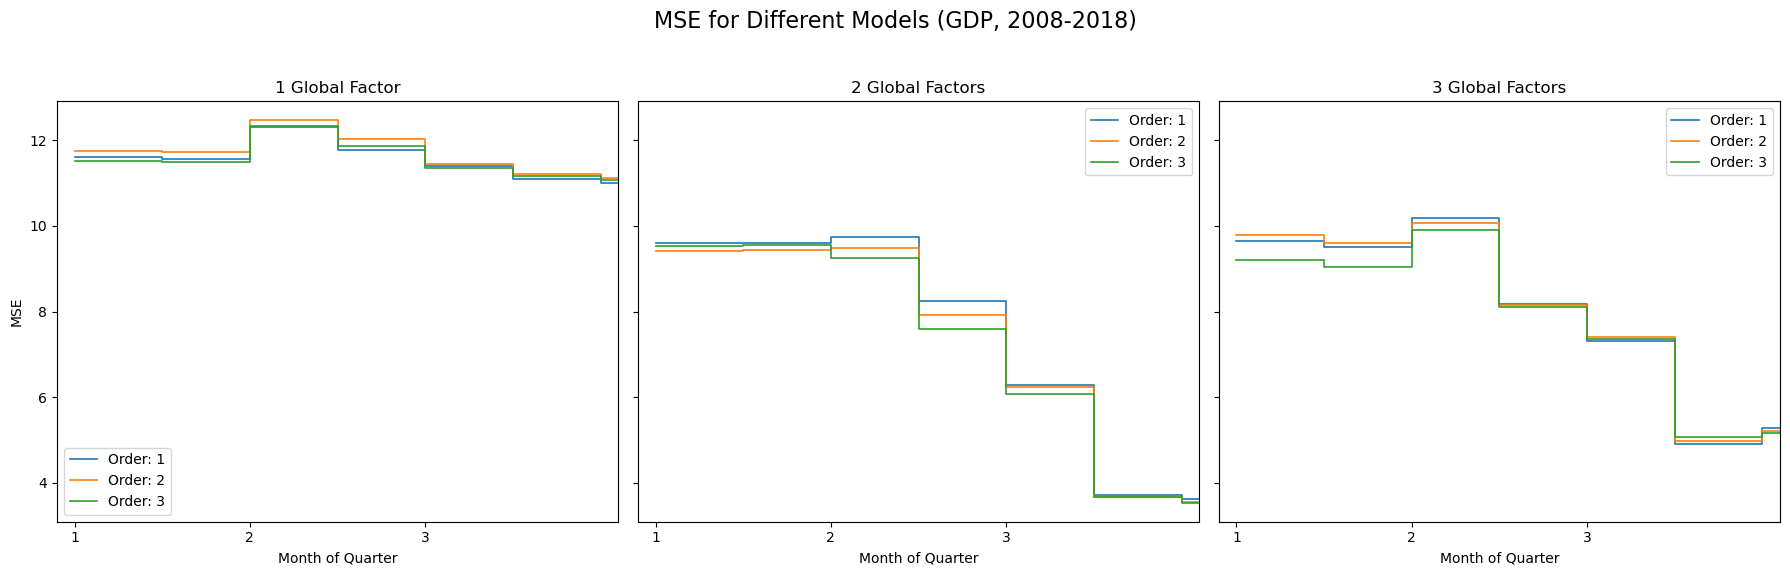

In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]
q_var = 'GDP'  

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Define the directory containing MSE files
mse_dir = f"../MSE/DFM_hard_surveys_global_factors_{q_var}"

# Create a figure with 1 row and 3 columns of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Loop over each number of global factors (1, 2, and 3)
for i, num_factors in enumerate(range(1, 4)):
    ax = axs[i]
    # Within each subplot, loop over factor orders 1 to 3
    for order in range(1, 4):
        # Construct file name based on the model's parameters
        factors_str = f"Global_{num_factors}_{order}"
        mse_file_name = f"MSE_{q_var}_{factors_str}.csv"
        mse_file_path = os.path.join(mse_dir, mse_file_name)
        
        # Load the MSE values from file
        mse_df = pd.read_csv(mse_file_path)
        # Construct y values based on the vintages
        y_values = [mse_df[col].iloc[0] for col in vintage_col_names]
        
        # Extend the y-values so the step function holds the last value
        y_extended = y_values.copy()
        y_extended.append(y_values[-1]) # Repeat the last value
        
        # Plot the step function for the current model
        ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                 label=f"Order: {order}")
        
    # Customize the subplot
    ax.set_xlabel("Month of Quarter")
    # Set ticks only at 1, 2, and 3 to mark the beginning of each month
    ax.set_xticks([1, 2, 3])
    ax.set_xlim(0.9, 4.1)
    ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
    if i == 0:  # Only the leftmost subplot gets the y-axis label
        ax.set_ylabel("MSE")
    ax.legend()

plt.suptitle(f"MSE for Different Models ({q_var}, 2008-2018)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
os.makedirs(f"../plots/DFM_hard_surveys_global_factors_{q_var}", exist_ok=True)
base_filename = os.path.join(f"../plots/DFM_hard_surveys_global_factors_{q_var}", f"DFM_hard_surveys_global_factors_2008-2018_{q_var}")
plt.savefig(f"{base_filename}.png", format="png")
plt.savefig(f"{base_filename}.eps", format="eps")

plt.show()

Plot MSE values for all models evaluated over the 2008–2010 and 2011-2018 periods.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


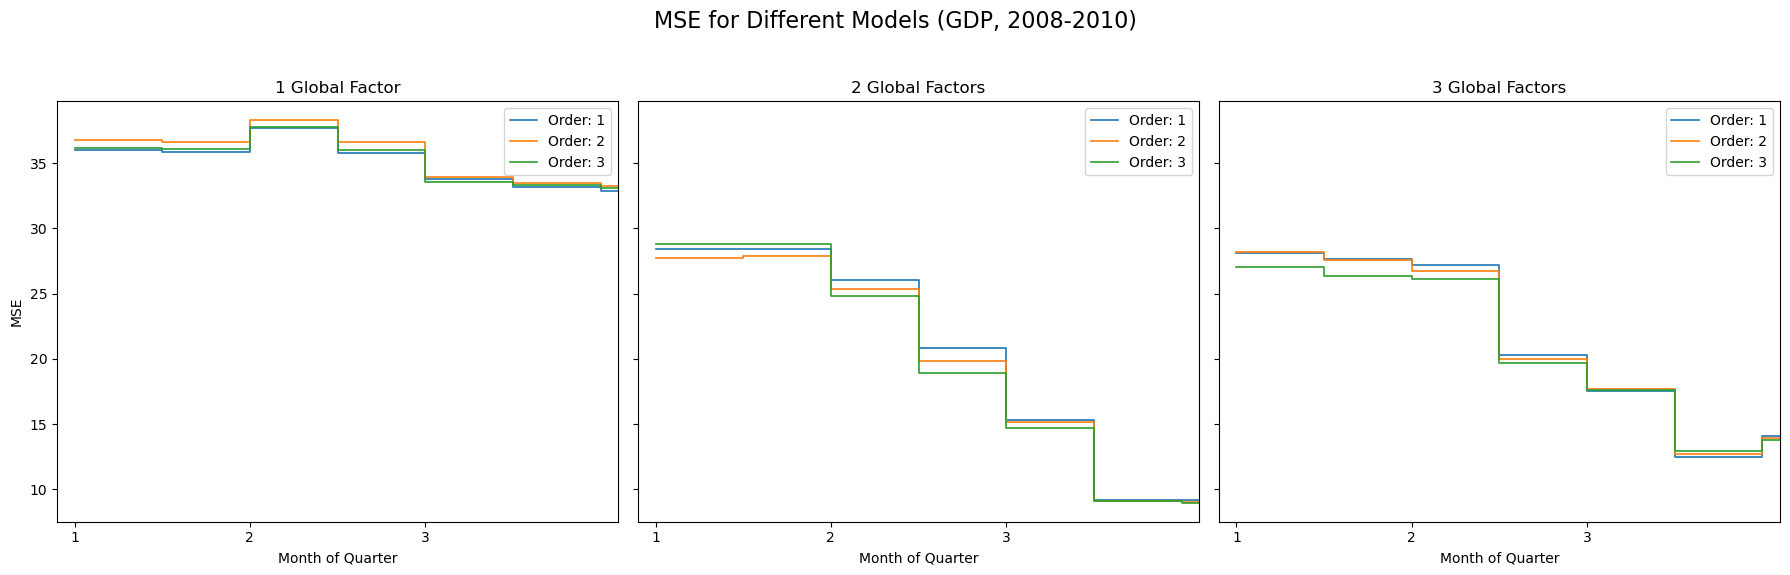

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


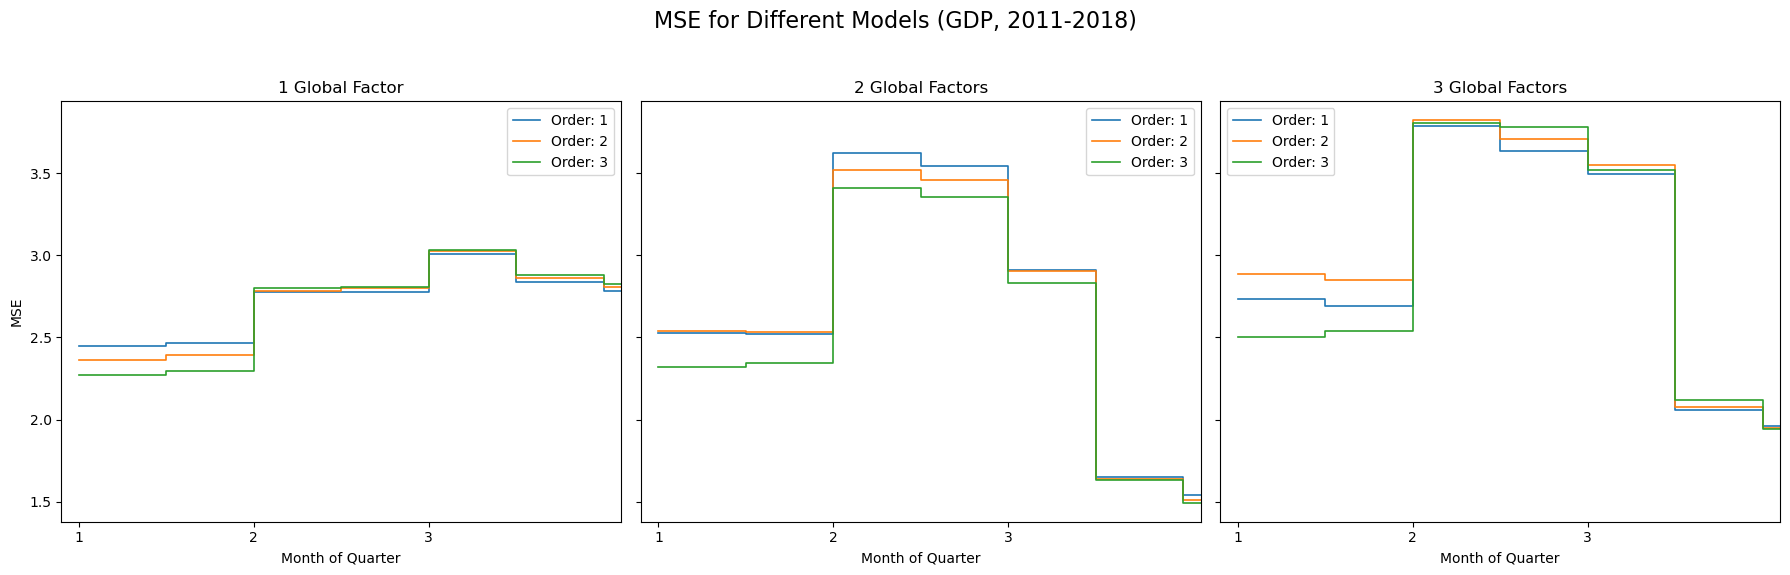

In [3]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
forecasts_dir = f"../forecasts/DFM_hard_surveys_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Define two periods
periods = {
    "2008-2010": lambda df: df["date_float"] < 2011,
    "2011-2018": lambda df: df["date_float"] >= 2011
}

# Define a mapping for each vintage to a numeric x-value
x_mapping = {
    "M1-01": 1.0,
    "M1-16": 1.5,
    "M2-01": 2.0,
    "M2-16": 2.5,
    "M3-01": 3.0,
    "M3-16": 3.5,
    "M4-01": 4.0
}

# Construct x values based on the vintages
x_values = [x_mapping[col] for col in vintage_col_names]
# Extend the x array so that the last step extends to the end of the x-axis
x_extended = x_values.copy()
x_extended.append(4.1)  # extend x-axis to 4.1

# Loop over each period and create a separate figure
for period_label, period_filter in periods.items():
    
    # Create a figure with 1 row and 3 columns of subplots
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    
    # Loop over each number of global factors (1, 2, and 3)
    for i, num_factors in enumerate(range(1, 4)):
        ax = axs[i]
        # Within each subplot, loop over factor orders 1 to 3
        for order in range(1, 4):
            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)
    
            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)
            
            # Merge forecasts with actual growth 
            merged = pd.merge(forecasts, actual_growth, on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)
            
            # Filter merged data for the current period
            merged_period = merged[ period_filter(merged) ]
            
            # Calculate MSE for each vintage column over the filtered period
            mse_dict = {}
            for col in vintage_col_names:
                mse = ((merged_period[col] - merged_period["growth"]) ** 2).mean()
                mse_dict[col] = mse
                
            # Construct y values based on the vintages
            y_values = [mse_dict[col] for col in vintage_col_names]
            
            # Extend the y-values so the step function holds the last value
            y_extended = y_values.copy()
            y_extended.append(y_values[-1]) # Repeat the last value
            
            # Plot the step function for the current model (order)
            ax.step(x_extended, y_extended, where='post', linewidth=1.2, 
                    label=f"Order: {order}")
            
        # Customize the subplot
        ax.set_xlabel("Month of Quarter")
        # Set ticks only at 1, 2, and 3 to mark the beginning of each month
        ax.set_xticks([1, 2, 3])
        ax.set_xlim(0.9, 4.1)
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:  # Only the leftmost subplot gets the y-axis label
            ax.set_ylabel("MSE")
        ax.legend()
   
    plt.suptitle(f"MSE for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_hard_surveys_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_hard_surveys_global_factors_{q_var}", f"DFM_hard_surveys_global_factors_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()

Plot forecasts vs actual growth values for all models and different time periods (2008-2010, 2008-2018, and 2011-2018).

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


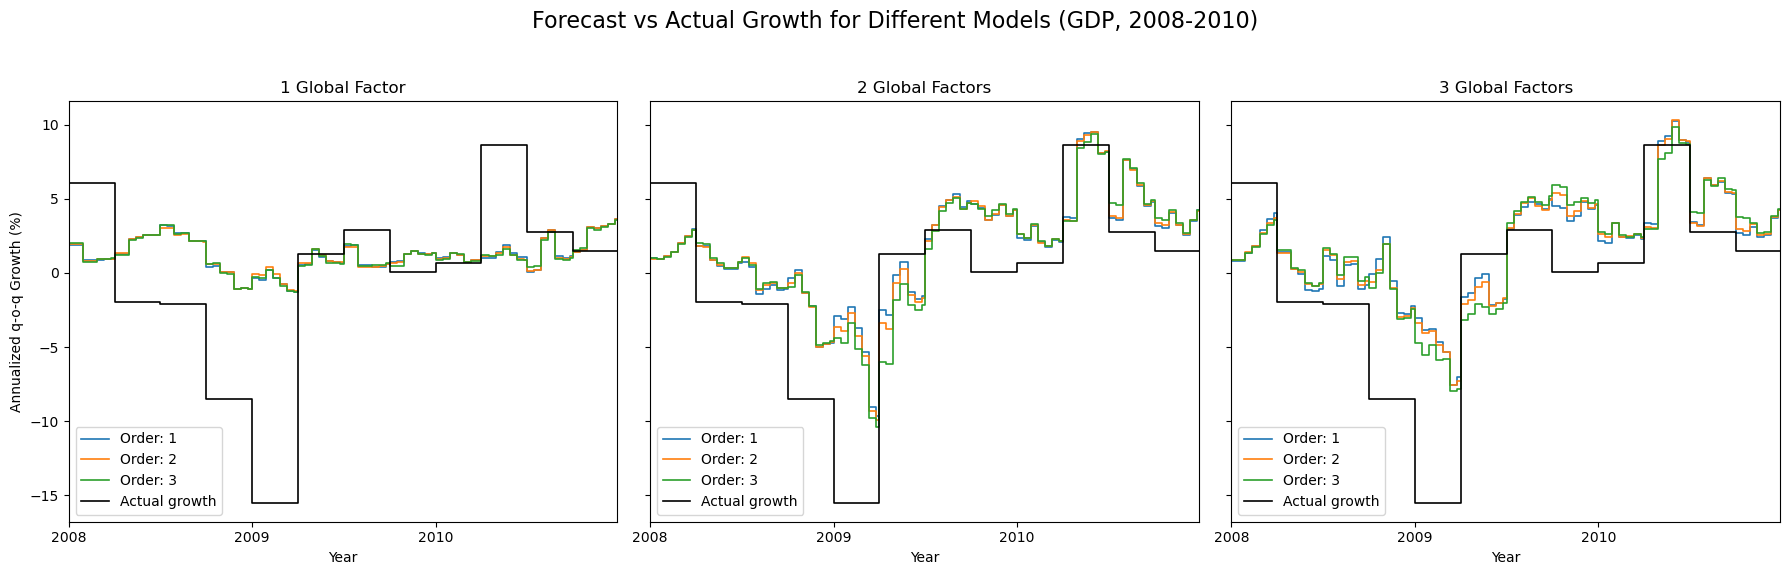

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


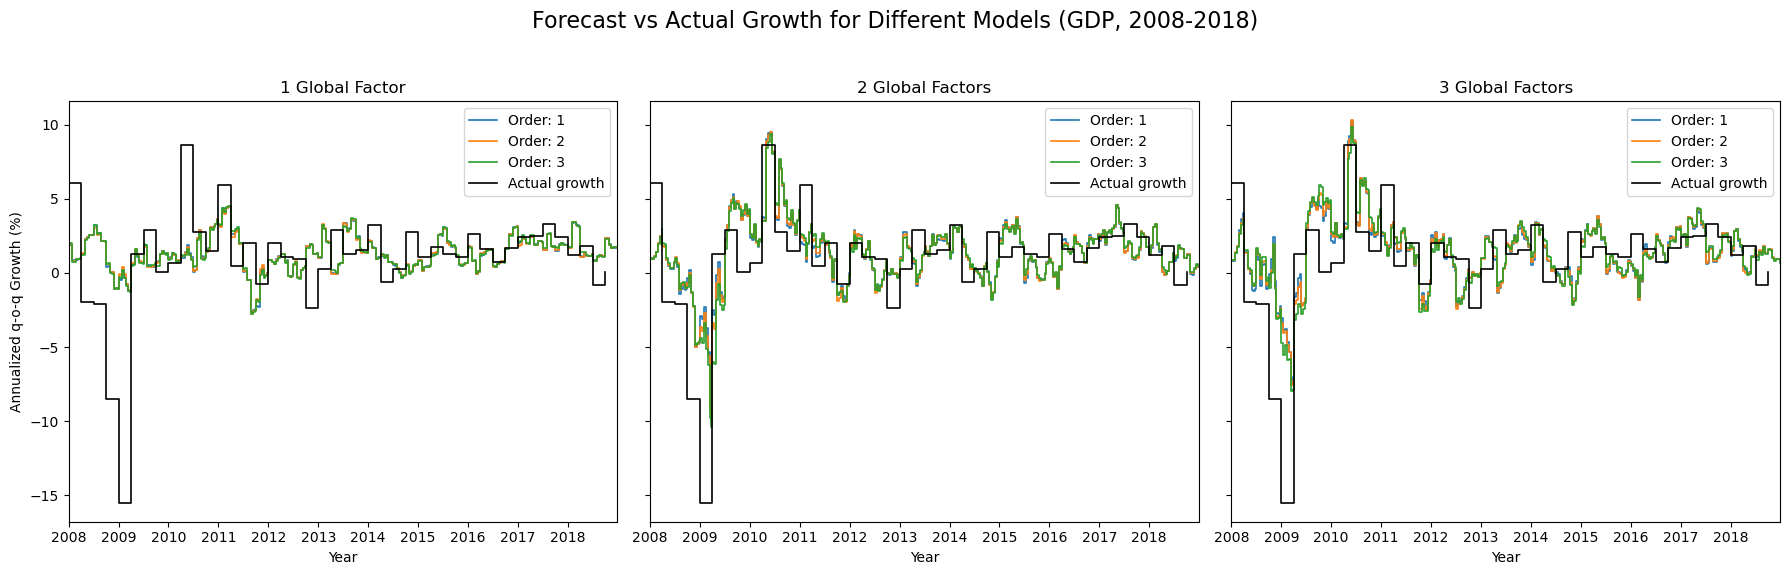

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


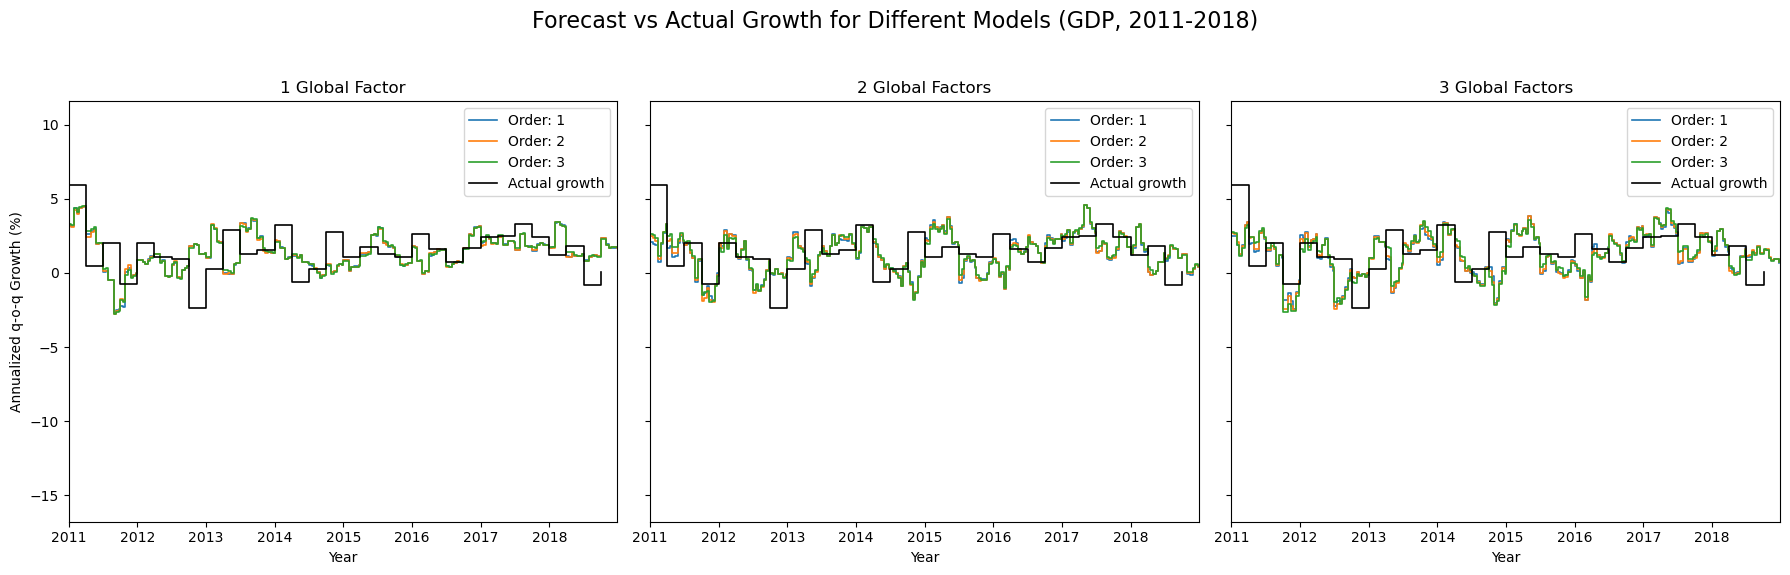

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Convert quarter strings like "2008-03" into a float (e.g. 2008.00 for Q1, 2008.25 for Q2, etc.)
def quarter_to_float(q_str):
    """
    Convert a string like 'YYYY-MM'
    into a float: e.g. 2008-03 -> 2008.00, 2008-06 -> 2008.25, etc.
    """
    year = int(q_str[:4])
    month = int(q_str[5:])
    # Map month to fraction of the year
    if month == 3:
        fraction = 0.00
    elif month == 6:
        fraction = 0.25
    elif month == 9:
        fraction = 0.50
    elif month == 12:
        fraction = 0.75
    return year + fraction

# Forecast variable and directories
q_var = 'GDP'
forecasts_dir = f"../forecasts/DFM_hard_surveys_global_factors_{q_var}"
actual_growth_file = f"../{q_var}_growth_actual.csv"

# Vintage columns
vintage_col_names = ["M1-01", "M1-16", "M2-01", "M2-16", "M3-01", "M3-16", "M4-01"]

# Assign 7 small offsets within each quarter, so each quarter has 7 forecast points
offsets = np.linspace(0, 0.23, 7)

# Load actual growth data and convert 'date' to float
actual_growth = pd.read_csv(actual_growth_file)
actual_growth["date_float"] = actual_growth["date"].apply(quarter_to_float)
actual_growth.sort_values("date_float", inplace=True)

# Build x,y arrays for the actual growth
x_act = actual_growth["date_float"].tolist()
y_act = actual_growth["growth"].tolist()

# Define period configurations: x-axis limits and tick positions for each period
period_configs = {
    "2008-2010": {"xlim": (2008, 2010.99), "xticks": list(range(2008, 2011))},
    "2008-2018": {"xlim": (2008, 2018.99), "xticks": list(range(2008, 2019))},
    "2011-2018": {"xlim": (2011, 2018.99), "xticks": list(range(2011, 2019))}
}

# Loop over each period configuration to create and save separate plots
for period_label, config in period_configs.items():

    # Create a figure with 1 row and 3 columns for the three global factor counts
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    # Loop over each global factor count (1, 2, and 3)
    for i, num_factors in enumerate([1, 2, 3]):
        ax = axs[i]

        # For each global factor count, plot forecasts for orders 1, 2, and 3
        for order in range(1, 4):

            # Construct forecast file name, e.g., "forecasts_GDP_Global_1_1.csv"
            factors_str = f"Global_{num_factors}_{order}"
            forecast_file_name = f"forecasts_{q_var}_{factors_str}.csv"
            forecast_file_path = os.path.join(forecasts_dir, forecast_file_name)

            # Load forecast data 
            forecasts = pd.read_csv(forecast_file_path, index_col=0)
            forecasts.index.name = "date"
            forecasts.reset_index(inplace=True)

            # Merge forecasts with actual growth dates
            merged = pd.merge(forecasts, actual_growth[['date']], on="date", how="inner")
            merged["date_float"] = merged["date"].apply(quarter_to_float)
            merged.sort_values("date_float", inplace=True)

            # Build forecast x and y arrays 
            x_fore = []
            y_fore = []
            for idx, row in merged.iterrows():
                base_x = row["date_float"]
                # For each of the 7 vintage columns, define an x-position and take that forecast value
                for j, col in enumerate(vintage_col_names):
                    x_fore.append(base_x + offsets[j])
                    y_fore.append(row[col])

            # Plot the forecast step curve for the current order
            ax.step(x_fore, y_fore, where='post', linewidth=1.2, label=f"Order: {order}")

        # Plot actual growth as a step plot in each subplot
        ax.step(x_act, y_act, where='post', color='black', linewidth=1.2, label="Actual growth")

        # Customize the subplot
        ax.set_xlabel("Year")
        ax.set_xlim(config["xlim"][0], config["xlim"][1])
        ax.set_xticks(config["xticks"])
        ax.set_title(f"{num_factors} Global Factor{'s' if num_factors > 1 else ''}")
        if i == 0:
            ax.set_ylabel("Annualized q-o-q Growth (%)")
        ax.legend()
        
    plt.suptitle(f"Forecast vs Actual Growth for Different Models ({q_var}, {period_label})", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    # Create the "plots" directory if it doesn't exist and save the figure as PNG and EPS
    os.makedirs(f"../plots/DFM_hard_surveys_global_factors_{q_var}", exist_ok=True)
    base_filename = os.path.join(f"../plots/DFM_hard_surveys_global_factors_{q_var}", f"DFM_hard_surveys_global_factors_forecast_vs_actual_{period_label}_{q_var}")
    plt.savefig(f"{base_filename}.png", format="png")
    plt.savefig(f"{base_filename}.eps", format="eps")

    plt.show()